In [1]:
import numpy as np
import pandas as pd
from collections import Counter, namedtuple
import matplotlib.pyplot as plt
from numbers import Number
from typing import List, Union
import uuid
import graphviz as gpz
from subprocess import check_call

In [2]:
class Node:
    def __init__(self, feature_idx:int=None, 
                 threshold:Number=None, 
                 left=None, 
                 right=None, 
                 leaf_value:Number=None):
        
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.leaf_value = leaf_value
        
        self.node_id = str(uuid.uuid4())
        
    
    def is_leaf_node(self):
        return self.leaf_value is not None
    
    
    def __eq__(self, other):
        if (self.leaf_value is None) and (other.leaf_value is None):
            return (self.leaf_value, self.node_id) == (other.leaf_value, other.node_id)
        else:
            return (self.feature_idx == other.feature_idx) and (self.threshold == other.threshold)
        
    
    def __hash__(self):
        if self.leaf_value is not None:
            return hash(self.node_id)
        else:
            return hash((self.feature_idx, self.threshold))
    
    
    def __str__(self):
        if self.feature_idx:
            return f"<feature_index={self.feature_idx}, threshold={self.threshold}>"
        else:
            return f"<leaf_value={self.leaf_value}>"
        
        
    def __repr__(self):
        if self.feature_idx:
            return f"<Node feature_index={self.feature_idx}, threshold={self.threshold}>"
        else:
            return f"<Node leaf_value={self.leaf_value}>"

In [3]:
class DecisionTree:
    def __init__(self, max_depth:int=10, 
                 min_samples_split:int=2, 
                 num_features:int=None,
                 feature_type_threshold:int=20,
                 impurity_measure:str="gini"):
        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_features = num_features
        self.feature_type_threshold = feature_type_threshold
        self.impurity_measure = self._entropy if (impurity_measure=="entropy" ) else self._gini
        
        self.root = None
        
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        
        X = X.values
        y = y.values
        
        if (self.num_features is None) or (self.num_features > X.shape[1]):
            self.num_features = X.shape[1]
            
        self.root = self._grow_tree(X, y)
        
    
    def predict(self, X:np.ndarray):
        X = X.values
        
        predictions = []
        
        for x in X:
            x_pred = self._traverse_tree(x, self.root)
            predictions.append(x_pred)
            
        return np.array(predictions)
        
        
    def _grow_tree(self, X:np.ndarray, y:np.ndarray, depth:int=0):
        samples_num, features_num = X.shape
        num_labels = np.unique(y).shape[0]
        
        if (depth>self.max_depth) or (samples_num<self.min_samples_split) or (num_labels==1):
            leaf_value = self._calculate_leaf_value(y)
            return Node(leaf_value=leaf_value)
            
        features_indices = np.random.choice(features_num, self.num_features, replace=False)
        
        self.features_types = self._calculate_features_types(X, features_indices, self.feature_type_threshold)
        
        best_feature_idx, best_threshold = self._best_split(X, y, features_indices)
        left_indices, right_indices = self._split(X[:, best_feature_idx], 
                                                  best_threshold, 
                                                  self.features_types[best_feature_idx].type)
        
        left = self._grow_tree(X[left_indices], y[left_indices], depth=depth+1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth=depth+1)
        
        return Node(feature_idx=best_feature_idx, 
                    threshold=best_threshold, 
                    left=left, 
                    right=right)
        
    
    
    def _best_split(self, X:np.ndarray, y:np.ndarray, features_indices:Union[np.ndarray, List]):
        best_info_gain = -1
        best_feature_idx = None
        best_threshold = None
            
        for i in features_indices:
            feature_column = X[:, i]
            feature_type = self.features_types[i].type
            feature_thresholds = np.unique(feature_column)
            
            for threshold in feature_thresholds:
                threshold_info_gain = self._info_gain(y, feature_column, threshold, feature_type)
                if threshold_info_gain > best_info_gain:
                    best_info_gain = threshold_info_gain
                    best_feature_idx = i
                    best_threshold = threshold
                    
        return best_feature_idx, best_threshold
    
    
    def _info_gain(self, y:np.ndarray, feature_column:np.ndarray, threshold:Number, feature_type):
        parent_impurity = self.impurity_measure(y)
        
        left_indices, right_indices = self._split(feature_column, threshold, feature_type)
        children_impurity = 0
        
        for idx in [left_indices, right_indices]:
            y_child = y[idx]
            weighted_child_impurity = (y_child.shape[0] / y.shape[0]) * self.impurity_measure(y_child)
            children_impurity += weighted_child_impurity
            
        return parent_impurity - children_impurity
    
    
    def _split(self, feature_column:np.ndarray, threshold:Number, feature_type:str):
        if feature_type == "Categorical":
            condition = (feature_column == threshold)
            left_indices = np.asarray(condition).nonzero()
            right_indices = np.asarray(~condition).nonzero()
            return left_indices, right_indices
        elif feature_type == "Numerical":
            condition = (feature_column <= threshold)
            left_indices = np.asarray(condition).nonzero()
            right_indices = np.asarray(~condition).nonzero()
            return left_indices, right_indices
        
        
    def _entropy(self, y:np.ndarray):
        classes_probs = np.bincount(y) / y.shape[0]
        p_log_p = -classes_probs * np.log2(classes_probs)
        return np.sum(p_log_p)
    
    
    def _gini(self, y:np.ndarray):
        classes_probs = np.bincount(y) / y.shape[0]
        probs_squares_sum = np.square(classes_probs)
        return 1 - np.sum(probs_squares_sum)
    
    
    def _calculate_features_types(self, X:np.ndarray, features_indices:np.ndarray, threshold:int):
        features_types = []
        
        feat_type = namedtuple("feature_type", ["index", "type"])
        
        for feature_idx in features_indices:
            feature_column = X[:, feature_idx]
            if np.unique(feature_column).shape[0] > threshold:
                features_types.append(feat_type(feature_idx, "Numerical"))
            else:
                features_types.append(feat_type(feature_idx, "Categorical"))
                
        return features_types
    
    
    def _calculate_leaf_value(self, y:np.ndarray):
        if np.all(np.unique(y)) in [0, 1]:
            y_counter = Counter(y)
            majority = y_counter.most_common(1)[0][0]
            return majority
        else:
            return np.mean(y)
    
    
    def _traverse_tree(self, x:np.ndarray, node):
        if node.is_leaf_node():
            return node.leaf_value
        
        feat_type = [feat_type.type for feat_type in self.features_types if feat_type.index == node.feature_idx][0]
        
        if feat_type == "Categorical":
            condition = (x[node.feature_idx] == node.threshold)
            return self._traverse_by_condition(x, node, condition=condition)
        elif feat_type == "Numerical":
            condition = (x[node.feature_idx] <= node.threshold)
            return self._traverse_by_condition(x, node, condition=condition)
            
            
    def _traverse_by_condition(self, x:np.ndarray, node:Node, condition=None):
            if condition:
                return self._traverse_tree(x, node.left)
            else:
                return self._traverse_tree(x, node.right)

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1234)

In [7]:
dt = DecisionTree(min_samples_split=3, max_depth=10)

In [8]:
dt.fit(X_train, y_train)

In [9]:
pred = dt.predict(X_test)

In [10]:
accuracy_score(y_test, pred)

0.8859649122807017

In [11]:
class DecisionTreeVisualizer:
    def __init__(self, node:Node, columns_names:np.ndarray=None):
        self.node = node
        self.columns_names = columns_names
        self.nodes_dict = {}

            
    def visualize_tree(self):
        if not self.nodes_dict:
            self._build_dict(self.node)
        
        dt_graph = gpz.Digraph(name="Decision Tree")
        
        for node, children in self.nodes_dict.items():
            node_name = None
            if self.columns_names is not None:
                node_name = f'feature="{self.columns_names[node.feature_idx]}", threshold={node.threshold}'
            else:
                node_name = str(node)
                
            for child in children:
                child_name = None
                if (self.columns_names is not None) and (child.feature_idx is not None):
                    child_name = f'feature="{self.columns_names[child.feature_idx]}", threshold={child.threshold}'
                else:
                    child_name = str(child)
                    
                if child.is_leaf_node():
                    leaf_id = str(uuid.uuid4())
                    dt_graph.attr("node", shape="box")
                    dt_graph.node(leaf_id, label=child_name)
                    dt_graph.edge(node_name, leaf_id)
                else:
                    dt_graph.attr("node", shape="box")
                    dt_graph.edge(node_name, child_name)
                    
        return dt_graph
    
    
    def saveas_png(self, file_name:str, directory:str=None):
        graph = self.visualize_tree()
        source = f"{file_name}.dot"
        graph.save(filename=f'{source}', directory=f'{directory}')
        if directory:
            check_call(['dot','-Tpng',f'{directory}/{source}','-o', f'{directory}/{file_name}.png'])
        else:
            check_call(['dot','-Tpng',f'{source}','-o', f'{file_name}.png'])
            
    
    def _build_dict(self, node:Node):

        if not node.feature_idx:
            return
        
        left_right = [child for child in [node.left, node.right] if child]

        if not left_right:
            self.nodes_dict[self.node] = []
            return
        
        children = [child for child in left_right if ( child.feature_idx or (child.leaf_value in [0,1]) ) ]
        if children:
            self.nodes_dict[node] = children 

        for child in children:
            self._build_dict(child)

In [12]:
dt_visualizer = DecisionTreeVisualizer(dt.root, X.columns)

In [13]:
graph = dt_visualizer.visualize_tree()

In [14]:
dt_visualizer.saveas_png("dt", directory='imgs')

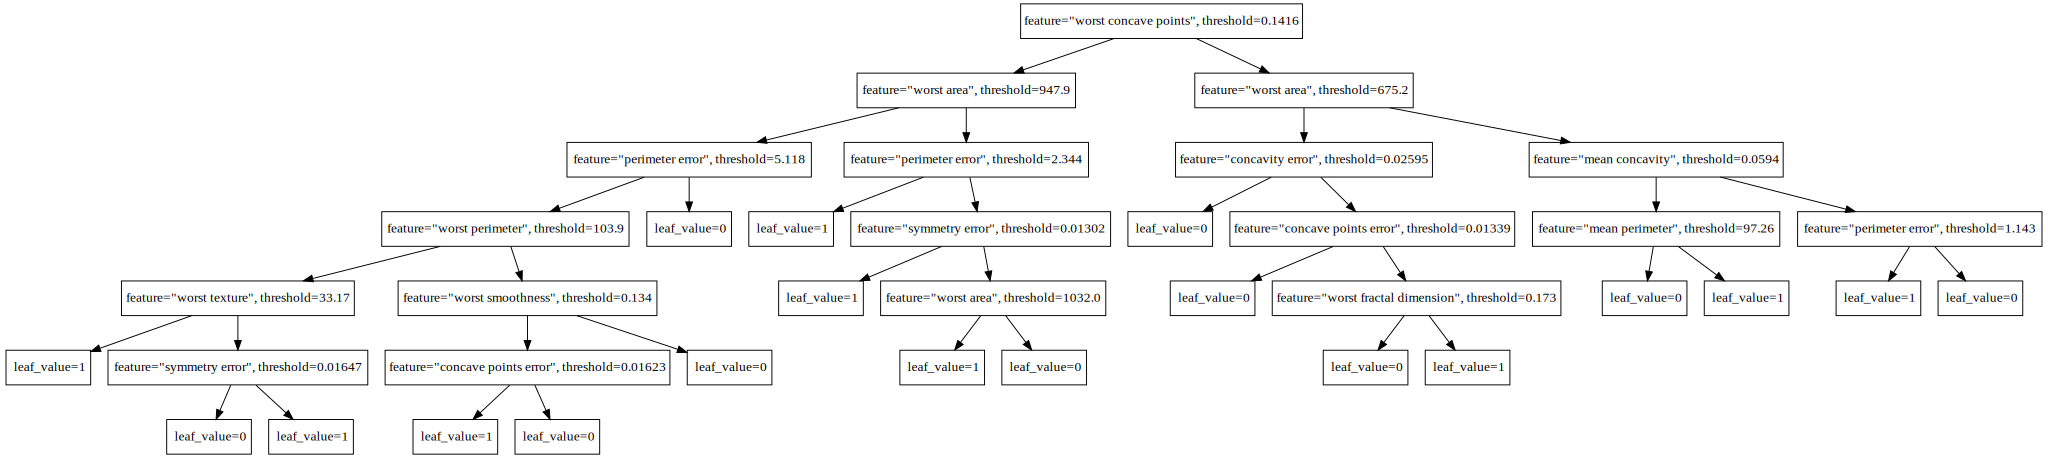

In [15]:
graph

In [16]:
# graph.save(filename="decision_tree.dot", directory='imgs')

In [17]:
# To generate a .dot file and a .pdf one. 
# dt_graph.view(filename='dt_graph', directory="imgs")

In [18]:
# from subprocess import check_call
# check_call(['dot','-Tpng','imgs/decision_tree.dot','-o','imgs/decision_tree.png'])